
![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-bear-100-Molprop.png)
## Molecular representation benchmarks - MolProp250K leadlike

## Background

Molecular representations are crucial for understanding molecular structure, predicting properties, QSAR studies, toxicology and chemical modeling and other aspects in drug discovery tasks. Therefore, benchmarks for molecular representations are critical tools that drive progress in the field of computational chemistry and drug design. In recent years, many large models have been trained for learning molecular representation. The aim is to evaluate if large pretrained models are capable of predicting various “easy-to-compute” molecular properties. 


## Benchmarking 

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties of leadlike molecules, gauging its effectiveness. Ideally, any pre-trained models should, at the very least, demonstrate good performance in those tasks before applying them to the downstream tasks. 

## Description of readout
 The computed properties are molecular weight, fraction of sp3 carbon atoms (fsp3), number of rotatable bonds, topological polar surface area, computed logP, formal charge, number of charged atoms, refractivity and number of aromatic rings. These properties are widely used in molecule design and molecule prioritization.

## Data resource
**Reference**: https://pubs.acs.org/doi/10.1021/acs.jcim.2c01253 

**Raw data**: https://cartblanche22.docking.org 

## Train/test split
The objective is to comprehend the proficiency of a model in predicting these 'easy' properties. In order to select the predictive models which is able to generalize to new chemical space, a scaffold split is used to generate train/test sets. 

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit
import polaris
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)
from polaris.utils.types import HubOwner, License, TargetType
import os
import pathlib

os.chdir(pathlib.Path("__file__").absolute().parents[1])
from utils import load_readme, save_figure
import warnings

warnings.filterwarnings("ignore")

In [3]:
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner

HubOwner(slug='polaristest', external_id=None, type=None)

In [4]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/molprop"
DATASET_DIR = "gs://polaris-public/datasets/molprop"
FIGURE_DIR = "gs://polaris-public/datasets/molprop/figures"

## Load existing data
> **Attention:** \
> ZINC22 is published in https://pubs.acs.org/doi/10.1021/acs.jcim.2c01253 and the dataset is downloaded from https://cartblanche22.docking.org \
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [03_ZINC22_250K_leadlike_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/blob/mvp/02_MolProp/03_ZINC22_250K_leadlike_benchmark.ipynb)

In [5]:
url = "gs://polaris-public/Data/zinc250k_leadlike/molecular_properties_v1.parquet"
table = pd.read_parquet(url)

In [6]:
annotations = {
    "smiles": ColumnAnnotation(
        description="Molecule Smiles string", modality="molecule"
    ),
    "mw": ColumnAnnotation(
        description="Molecular weight computed with <datamol.descriptor.mw>"
    ),
    "fsp3": ColumnAnnotation(
        description="Fraction of saturated carbons computed with <datamol.descriptor.fsp3>"
    ),
    "n_rotatable_bonds": ColumnAnnotation(
        description="A rotatable bond is defined as any single non-ring bond, attached to a non-terminal, non-hydrogen atom, computed with <datamol.descriptor.n_rotatable_bonds>"
    ),
    "tpsa": ColumnAnnotation(
        description="Topological polar surface area of a molecule is defined as the surface sum over all polar atoms or molecules, primarily oxygen and nitrogen, also including their attached hydrogen atoms. Computed with <datamol.descriptor.tpsa>"
    ),
    "clogp": ColumnAnnotation(
        description="Wildman-Crippen LogP value, computed with <datamol.descriptor.clogp>"
    ),
    "formal_charge": ColumnAnnotation(
        description="Formal Charge is a charge assigned to an atom under the assumption that all electrons in bonds are shared equally, computed with <datamol.descriptor.formal_charge>"
    ),
    "n_charged_atoms": ColumnAnnotation(
        description="Number of charged atoms in a molecule, computed with <datamol.descriptor.n_charged_atoms>"
    ),
    "refractivity": ColumnAnnotation(
        description="The total polarizability of a mole of a substance and is dependent on the temperature, the index of refraction, and the pressure. Computed with <datamol.descriptor.refeactivity>"
    ),
    "n_aromatic_rings": ColumnAnnotation(
        description="Number of aromatic rings in the molecule, computed with <datamol.descriptor.n_aromatic_rings>"
    ),
}

###  Define the `Dataset` object

In [7]:
dataset_name = "molprop-250k-leadlike-1"
readme_name = "molprop250kleadlike_v1"

In [8]:
dataset = Dataset(
    table=table[annotations.keys()],
    name=dataset_name,
    description=" Leadlike molecule properties computed for ZINC22 250K dataset. Those molecular properties are used to examine the usefulness of any pretrained models. Especially, any model for generation purpose should not fail on these tasks.",
    source="https://pubs.acs.org/doi/10.1021/acs.jcim.2c01253",
    annotations=annotations,
    owner=owner,
    tags=["representation", "properties"],
    license=License(id="CC-BY-4.0"),
    readme=load_readme(f"gs://polaris-public/readme/datasets/{readme_name}_readme.md"),
)

In [9]:
# save the dataset
DATASET_SAVE_DIR = f"{DATASET_DIR}/{dataset_name}"
dataset.to_json(DATASET_SAVE_DIR)

'gs://polaris-public/datasets/molprop/molprop-250k-leadlike-1/dataset.json'

## Create scaffold split for `molProp250K_zinc15` dataset
> **Note:**
> Here we use the splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties. \
To select the predictive models that are able to generalize to new chemical space, a scaffold split is used to generate train/test sets. 

In [10]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit

TEST_SIZE = 0.2
SEED = 111
splitter = ScaffoldSplit(
    smiles=dataset.table.smiles.values,
    n_jobs=-1,
    test_size=TEST_SIZE,
    random_state=SEED,
)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

**Visualize the train/test distribution in the chemical space**

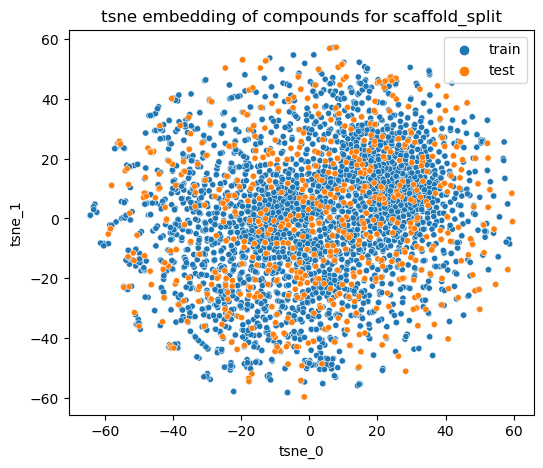

In [31]:
from utils import display_chemspace

data_name = "molprop250kleadlike_v1"
fig = display_chemspace(
    dataset.table.copy(), "smiles", split=scaffold_split, split_name="scaffold_split"
)
method = "tsne"
save_figure(
    fig,
    remote_path=f"{FIGURE_DIR}/{data_name}_{method}_scaffold_split.png",
    local_path=f"figures/{data_name}_{method}_scaffold_split.png",
)

## Create a Benchmark for MolProp250KLeadlike dataset
### Multitask for all properties with a shared scaffold split. 

In [11]:
benchmark_version = "1"
benchmark_name = f"molprop-250k-leadlike-r-{benchmark_version}"
readme_name = f"molprop250kleadlike_multitask_reg_v{benchmark_version}"

In [12]:
data_cols = [
        "mw",
        "fsp3",
        "n_rotatable_bonds",
        "tpsa",
        "clogp",
        "formal_charge",
        "n_charged_atoms",
        "refractivity",
        "n_aromatic_rings",
    ]

In [17]:
benchmark = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    targetTypes={col: TargetType.REGRESSION for col in data_cols},
    input_cols="smiles",
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    tags=["representation", "properties"],
    description="A multitask benchmark designed to predict nine molecular properties for 250,000 leadlike compounds sourced from ZINC22, with a focus on molecular representation.",
    owner=owner,
    readme=load_readme(
        f"gs://polaris-public/readme/benchmarks/{readme_name}_readme.md"
    ),
)

### Save the benchmark

In [18]:
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark.to_json(BENCHMARK_SAVE_DIR)